In [36]:
%load_ext autoreload 

import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader

from collections import defaultdict
from joblib import Parallel, delayed, pool
from multiprocessing import cpu_count
from IPython.display import clear_output
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm_notebook

from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso
from lightgbm import LGBMRegressor
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from utils import load_dataset

import warnings
warnings.filterwarnings("ignore")
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [20]:
track = 'Circle'
mouse = 22
day = 1

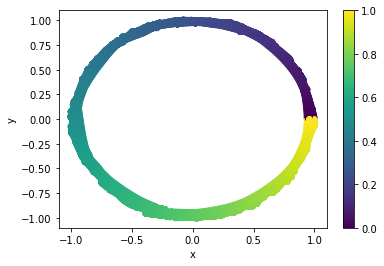

In [2]:
data, targets = load_dataset('data', mouse=mouse, dayday, track=, trim0=1500, trim1=100)

plt.scatter(targets['x'], targets['y'], c=targets['phi'])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

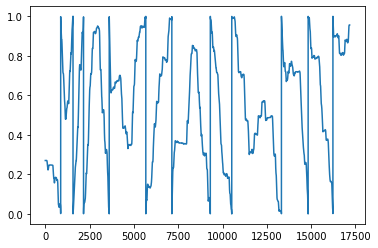

In [48]:
plt.plot(targets['phi'])

# Sklearn models

In [76]:
def MAPE(y, y_pred):
    return (np.linalg.norm(y - y_pred, ord=1, axis=1) / np.linalg.norm(y, ord=1, axis=1)).mean()

def cross_validate(est, X,y, scorer):
    cv_scores = cross_val_score(est, X, y, scoring=scorer, n_jobs=1, cv=5)
    return [cv_scores.mean(), cv_scores.std()]

def train_test_validation(est, X,y, scorer, shuffle=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=shuffle)
    est.fit(X_train, y_train)
    return scorer(est, X_test, y_test)

r2_scorer = make_scorer(r2_score, greater_is_better=True)

In [4]:
X = data['cadata'].T
coords = np.stack([targets['x'], targets['y']], -1)

In [5]:
coords.shape, X.shape

((17175, 2), (17175, 522))

In [69]:
est = Ridge(random_state=42)
est_mo = MultiOutputRegressor(est)
r2_scores = cross_validate(est_mo, X, coords, r2_scorer)

In [70]:
r2_scores

[0.7592326807401732, 0.08352700385604267]

In [72]:
# now on train-test split
train_test_validation(est_mo, X,coords, r2_scorer, shuffle=True)

0.97500389501239

 - shuffling increase R2 score on whole data cross-validation or train-test split
 - reconstruction error reduces with time-window moving (Nikita's observation)

In [ ]:
# est_mo.fit(cadata_.T, coords_)
# coords_pred_ = est_mo.predict(cadata_.T)
# mae_pred = np.linalg.norm(coords_normalized - coords_pred_, ord=1, axis=1) / np.linalg.norm(coords_normalized, ord=1, axis=1)
# plt.hist(mae_pred, bins=50)
# plt.show()

In [ ]:
# plt.scatter(coords_normalized[:,0], coords_normalized[:,1], alpha=0.1)
# plt.scatter(coords_normalized[:,0][high_mae_mask], coords_normalized[:,1][high_mae_mask], c='r')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('M22, D1, Regression MAPE above 0.6')
# plt.show()

In [ ]:
# plt.figure(figsize=(15,5), dpi=200) 
# plt.plot(np.arange(T),coords_[:,0])
# plt.scatter(np.arange(T)[high_mae_mask], coords_[:,0][high_mae_mask], alpha=0.5, color='r')
# plt.show()

# Cross-validation over time-windows

In [89]:
dt = 5000
T = X.shape[0]
iterator = np.arange(0,T-dt,100)

In [78]:
r2_scores = Parallel(n_jobs=20,verbose=0)(delayed(train_test_validation)(est_mo, 
                                                                         X[i:i+dt,:], 
                                                                         coords[i:i+dt,:],
                                                                         r2_scorer) for i in tqdm_notebook(iterator))
    
r2_scores = np.array(r2_scores)

  0%|          | 0/122 [00:00<?, ?it/s]

In [81]:
r2_scores_cv = Parallel(n_jobs=20,verbose=0)(delayed(cross_validate)(est_mo, 
                                                                     X[i:i+dt,:], 
                                                                     coords[i:i+dt,:],
                                                                     r2_scorer) for i in tqdm_notebook(iterator))
    
r2_scores_cv = np.array(r2_scores_cv)

  0%|          | 0/122 [00:00<?, ?it/s]

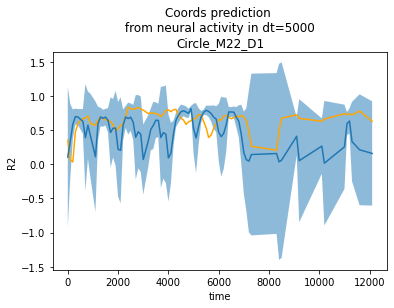

In [93]:
mask = (r2_scores > 0)*(r2_scores_cv[:,0] > 0)
# mask = np.ones_like(r2_scores).astype(bool) #

plt.plot(iterator[mask], r2_scores[mask], color='orange')
plt.plot(iterator[mask], r2_scores_cv[:,0][mask])
plt.fill_between(x=iterator[mask],
                 y1=r2_scores_cv[:,0][mask] - r2_scores_cv[:,1][mask],
                 y2=r2_scores_cv[:,0][mask] + r2_scores_cv[:,1][mask], 
                 alpha=0.5)

plt.title(f'Coords prediction \n from neural activity in dt={dt} \n' + f'{track}_M{mouse}_D{day}') # name
plt.xlabel('time') 
plt.ylabel('R2')
plt.show()

# MLP

In [106]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim=2, hidden_dim=256):
        super().__init__() 
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.layers =  nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.Linear(hidden_dim, output_dim))
        
        
    def forward(self, x):
        x = self.layers(x)
        return x
        

/media/hpc2_storage/ibulygin/miniconda3/envs/mink/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


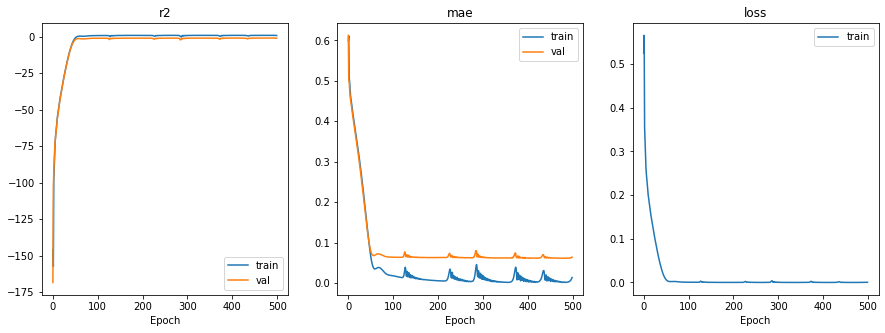

In [63]:
# define data
data_numpy = X.copy()
target_numpy = coords 

# train-test split
N = data_numpy.shape[0]
indexes = np.arange(N)
np.random.shuffle(indexes)
val_ratio = 0.1
split_index = int(val_ratio*N)
val_indexes = indexes[:split_index]
train_indexes = indexes[split_index:]   

data_tensor = torch.from_numpy(data_numpy).cuda().float()
data_val_tensor = data_tensor[val_indexes]
data_train_tensor = data_tensor[train_indexes]

target_tensor = torch.from_numpy(target_numpy).float().cuda()
target_val_tensor = target_tensor[val_indexes]
target_train_tensor = target_tensor[train_indexes]

model = MLP(data_numpy.shape[1], output_dim=target_numpy.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

history_train = defaultdict(list)
history_val = defaultdict(list)

for epoch in tqdm_notebook(range(500)):
    opt.zero_grad()
    pred_tensor = model(data_train_tensor)
    loss = criterion(target_train_tensor, pred_tensor)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    
    history_train['r2'].append(r2_score(target_train_tensor.detach().cpu().numpy(), 
                       pred_tensor.detach().cpu().numpy()))
    
    mae = torch.norm(target_train_tensor - pred_tensor, p=1, dim=1)
    history_train['mae'].append(mae.mean().item())
    history_train['loss'].append(loss.item())

    
    # validation
    with torch.no_grad():
        pred_tensor = model(data_val_tensor)

        history_val['r2'].append(r2_score(target_val_tensor.detach().cpu().numpy(), 
                                   pred_tensor.detach().cpu().numpy()))

        mae = torch.norm(target_val_tensor - pred_tensor, p=1, dim=1)
        history_val['mae'].append(mae.mean().item())
    

fig, axes = plt.subplots(nrows=1, ncols=len(history_train), figsize=(15,5))
for i,(k,v) in enumerate(history_train.items()):
    axes[i].plot(v, label='train')
    if k in history_val.keys():
        axes[i].plot(history_val[k], label='val')
    axes[i].set_xlabel('Epoch')
    axes[i].set_title(k)
    axes[i].legend()
plt.show()